In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

pd.set_option('mode.chained_assignment',None)

In [132]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter % 5 == 0:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [362]:
# Load full Data
df_full = pd.read_csv('data/processed/SimpleNNData.csv', index_col=0, parse_dates = [1])
y = df_full.time_to_reservation
df_full.drop(columns=['time_to_reservation'], inplace=True)
weather_var = list(df_full.columns[-22:-1])

## Simple network

In [363]:
df = df_full.drop(columns=['hour_index', 'dist_to_station', 'degree']+weather_var, inplace = False)
df['leave_fuel'] = df['leave_fuel']/100
y = y[df.iloc[:,0].dt.month == 8]
df = df[df.iloc[:,0].dt.month == 8]
df.drop(columns = ['index'], inplace=True)

In [364]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

#train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|weekend')], axis = 1)
#val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|weekend')], axis = 1)
#test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|weekend')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [365]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(269,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(64,16),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.2),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=269, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 18337


In [366]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 0.01) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 19.180083 , Valid Loss 16.917976 ,Train R2 0.171398, Valid R2 0.168535
EarlyStopping counter: 5 out of 10
Epoch 11: Train Loss 16.506430 , Valid Loss 16.520598 ,Train R2 0.216722, Valid R2 0.188065
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 16: Train Loss 16.375359 , Valid Loss 16.560603 , Train R2 0.224537, Valid R2 0.186099


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

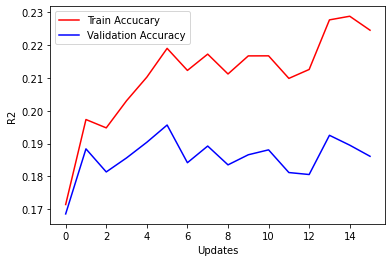

In [367]:
# setting hyperparameters and gettings epoch sizes
batch_size = 256
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

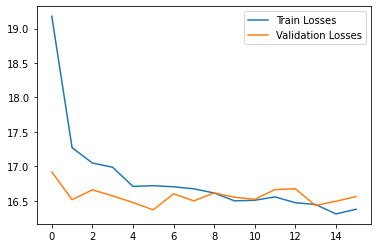

0.18788583309347617


In [368]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

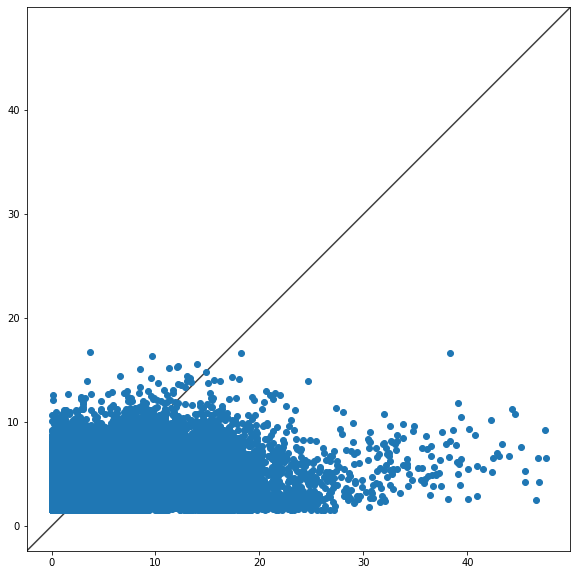

In [10]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## No Zones

In [11]:
df = df_full.iloc[:,:11]
df.drop(columns = ['degree','index','hour_index'], inplace = True)
df['leave_fuel'] = df['leave_fuel']/100
df

,leave_fuel,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1
0,0.30,0,1.000000,0.000364,0,0,1,0
1,0.86,0,0.999999,0.001018,0,0,1,0
2,0.04,0,0.999997,0.002327,1,0,0,0
3,0.30,0,0.999968,0.007999,0,0,1,0
4,0.32,0,0.999957,0.009236,0,1,0,0
...,...,...,...,...,...,...,...,...
326587,0.94,0,0.999934,-0.011490,0,0,1,0
326588,0.59,0,0.999970,-0.007708,1,0,0,0
326589,0.48,0,0.999980,-0.006327,1,0,0,0
326590,0.23,0,0.999990,-0.004363,0,0,1,0


In [12]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

#train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|weekend')], axis = 1)
#val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|weekend')], axis = 1)
#test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|weekend')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [13]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(8,256),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.0),
            nn.Linear(256,128),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.0),
            nn.Linear(128,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
) 35329


In [14]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 0.01) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 19.771781 , Valid Loss 19.381004 ,Train R2 0.100959, Valid R2 0.099454
EarlyStopping counter: 5 out of 10
Epoch 11: Train Loss 18.899002 , Valid Loss 19.343841 ,Train R2 0.103706, Valid R2 0.101181
Epoch 21: Train Loss 18.797081 , Valid Loss 19.247885 ,Train R2 0.108724, Valid R2 0.105640
Epoch 31: Train Loss 18.755436 , Valid Loss 19.202675 ,Train R2 0.111143, Valid R2 0.107740
Epoch 41: Train Loss 18.725452 , Valid Loss 19.170662 ,Train R2 0.112759, Valid R2 0.109228
EarlyStopping counter: 5 out of 10
Epoch 51: Train Loss 18.707564 , Valid Loss 19.159734 ,Train R2 0.113410, Valid R2 0.109736
Epoch 61: Train Loss 18.695877 , Valid Loss 19.147734 ,Train R2 0.114129, Valid R2 0.110293
EarlyStopping counter: 5 out of 10
Epoch 71: Train Loss 18.697796 , Valid Loss 19.142816 ,Train R2 0.114365, Valid R2 0.110522
Epoch 81: Train Loss 18.696615 , Valid Loss 19.141590 ,Train R2 0.114377, Valid R2 0.110579
Epoch 91: Train Loss 18.690977 , Valid Loss 19.137781 ,Train R2 0.1

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

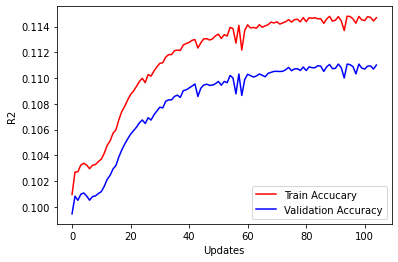

In [15]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

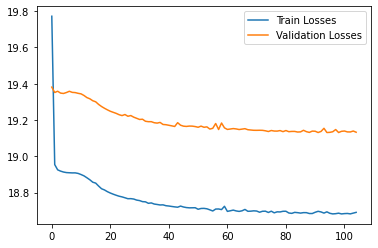

0.1091207652844437


In [16]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

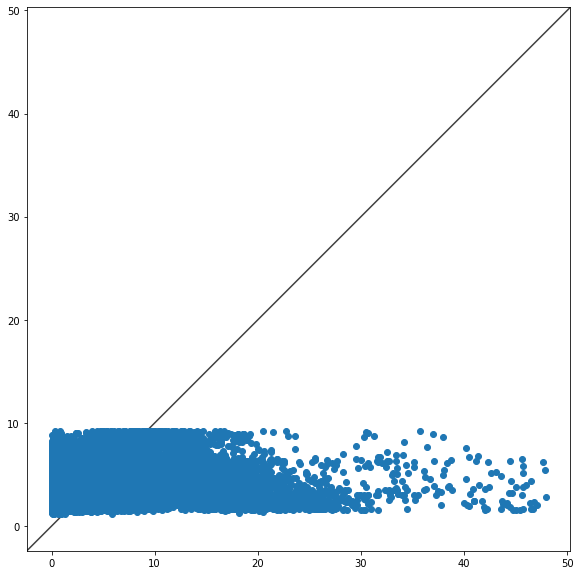

In [17]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With embedding

In [18]:
df = df_full.drop(columns=['dist_to_station', 'degree', 'index', 'hour_index']+weather_var, inplace = False)
df['Zone'] = df.filter(regex = 'lz').values.argmax(1)
df = df.drop(df.filter(regex='lz').columns,axis=1)
df['leave_fuel'] = df['leave_fuel']/100
df

,leave_fuel,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,Zone
0,0.30,0,1.000000,0.000364,0,0,1,0,209
1,0.86,0,0.999999,0.001018,0,0,1,0,138
2,0.04,0,0.999997,0.002327,1,0,0,0,56
3,0.30,0,0.999968,0.007999,0,0,1,0,235
4,0.32,0,0.999957,0.009236,0,1,0,0,75
...,...,...,...,...,...,...,...,...,...
326587,0.94,0,0.999934,-0.011490,0,0,1,0,63
326588,0.59,0,0.999970,-0.007708,1,0,0,0,45
326589,0.48,0,0.999980,-0.006327,1,0,0,0,75
326590,0.23,0,0.999990,-0.004363,0,0,1,0,148


In [19]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [20]:
# define network
class Net(nn.Module):

    def __init__(self, emb_dim):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding(261,emb_dim)

        self.seq = nn.Sequential(
            nn.Linear(8+emb_dim,256),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(256,128),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x_emb_in = x[:,-1].long()
        x_emb_out = self.embedding(x_emb_in)
        x = torch.cat([x[:,:-1],x_emb_out], axis = 1)
        x = self.seq(x)
        return x


net = Net(emb_dim = 4)
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (embedding): Embedding(261, 4)
  (seq): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 45589


In [21]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 0.0005) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 19.848476 , Valid Loss 18.314854 ,Train R2 0.133672, Valid R2 0.136480
Epoch 11: Train Loss 17.074242 , Valid Loss 16.860397 ,Train R2 0.209261, Valid R2 0.205055
Epoch 21: Train Loss 16.793150 , Valid Loss 16.638666 ,Train R2 0.222313, Valid R2 0.215510
EarlyStopping counter: 5 out of 10
Epoch 31: Train Loss 16.678711 , Valid Loss 16.616974 ,Train R2 0.225816, Valid R2 0.216532
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 34: Train Loss 16.650041 , Valid Loss 16.614143 , Train R2 0.227368, Valid R2 0.216666


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

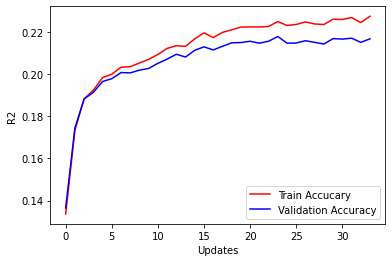

In [22]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

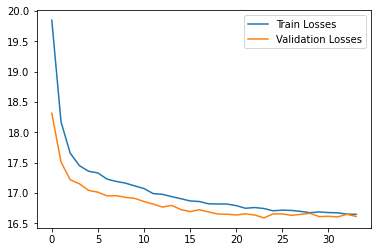

0.21753237664170855


In [23]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

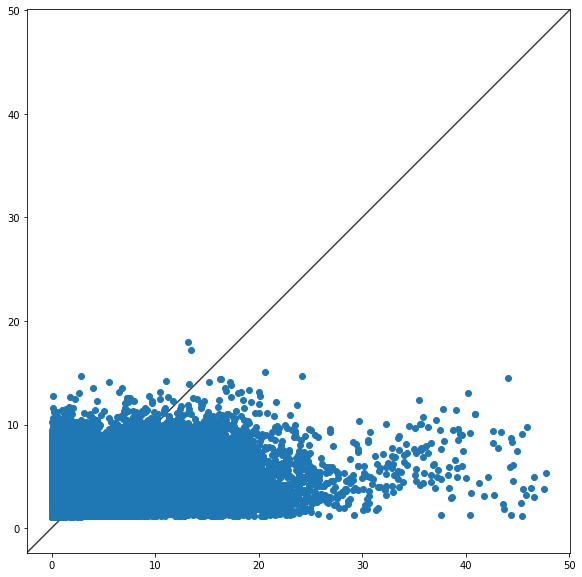

In [24]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With degree

In [25]:
df = df_full.drop(columns=['dist_to_station', 'index', 'hour_index']+weather_var, inplace = False)
df['leave_fuel'] = df['leave_fuel']/100
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,0.30,12.529378,0,1.000000,0.000364,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.86,14.027280,0,0.999999,0.001018,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.04,17.751882,0,0.999997,0.002327,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.30,1.806991,0,0.999968,0.007999,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.32,13.214864,0,0.999957,0.009236,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,0.94,20.556195,0,0.999934,-0.011490,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
326588,0.59,14.221806,0,0.999970,-0.007708,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326589,0.48,16.451925,0,0.999980,-0.006327,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326590,0.23,15.140361,0,0.999990,-0.004363,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data['degree'] = (train_data['degree']-1)/(train_data['degree'].max()-1)
val_data['degree'] = (val_data['degree']-1)/(val_data['degree'].max()-1)
test_data['degree'] = (test_data['degree']-1)/(test_data['degree'].max()-1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [27]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(270,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            #nn.Linear(64,64),
            #nn.ReLU(),#nn.BatchNorm1d(128)),
            #nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=270, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
) 43009


In [28]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 19.106171 , Valid Loss 17.013054 ,Train R2 0.205425, Valid R2 0.201773
Epoch 11: Train Loss 16.208240 , Valid Loss 16.240314 ,Train R2 0.256901, Valid R2 0.238029
Epoch 21: Train Loss 16.020116 , Valid Loss 16.134039 ,Train R2 0.269937, Valid R2 0.243015
EarlyStopping counter: 5 out of 10
Epoch 31: Train Loss 15.851268 , Valid Loss 16.081451 ,Train R2 0.278039, Valid R2 0.245483
EarlyStopping counter: 5 out of 10
Epoch 41: Train Loss 15.740943 , Valid Loss 16.086717 ,Train R2 0.283370, Valid R2 0.245236
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 44: Train Loss 15.725619 , Valid Loss 16.062302 , Train R2 0.283740, Valid R2 0.246381


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

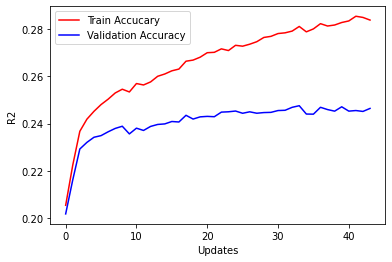

In [29]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

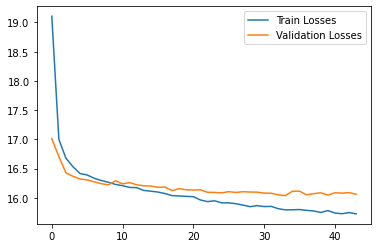

0.2460074262809735


In [30]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

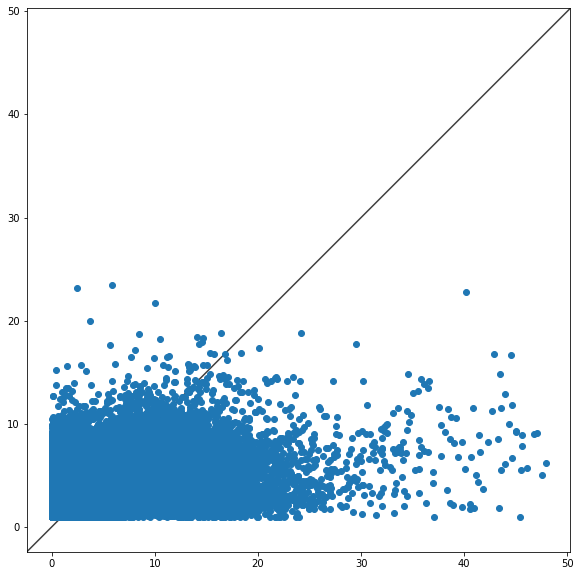

In [31]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With Dist to Station

In [32]:
df = df_full.drop(columns=weather_var+['degree', 'index', 'hour_index'], inplace = False)
df['leave_fuel'] = df['leave_fuel']/100
df['dist_to_station'] = df['dist_to_station']/5320
df

,leave_fuel,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,...,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203,dist_to_station
0,0.30,0,1.000000,0.000364,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.072717
1,0.86,0,0.999999,0.001018,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.206071
2,0.04,0,0.999997,0.002327,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.152756
3,0.30,0,0.999968,0.007999,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.168720
4,0.32,0,0.999957,0.009236,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.112613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,0.94,0,0.999934,-0.011490,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.051773
326588,0.59,0,0.999970,-0.007708,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.102707
326589,0.48,0,0.999980,-0.006327,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.115706
326590,0.23,0,0.999990,-0.004363,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.093152


In [33]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|weekend')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|weekend')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|weekend')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [34]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(270,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(64,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(64,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=270, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 25729


In [35]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 20.008353 , Valid Loss 17.303653 ,Train R2 0.181549, Valid R2 0.178108
Epoch 11: Train Loss 16.525900 , Valid Loss 16.435862 ,Train R2 0.247892, Valid R2 0.219327
Epoch 21: Train Loss 16.337723 , Valid Loss 16.386015 ,Train R2 0.259958, Valid R2 0.221695
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 27: Train Loss 16.214654 , Valid Loss 16.420213 , Train R2 0.263774, Valid R2 0.220070


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

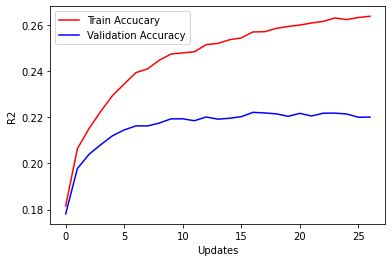

In [36]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

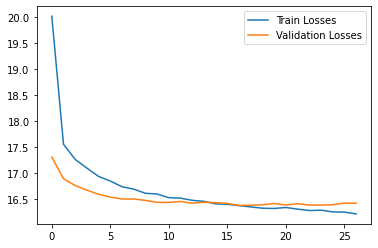

0.2198371446367925


In [37]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

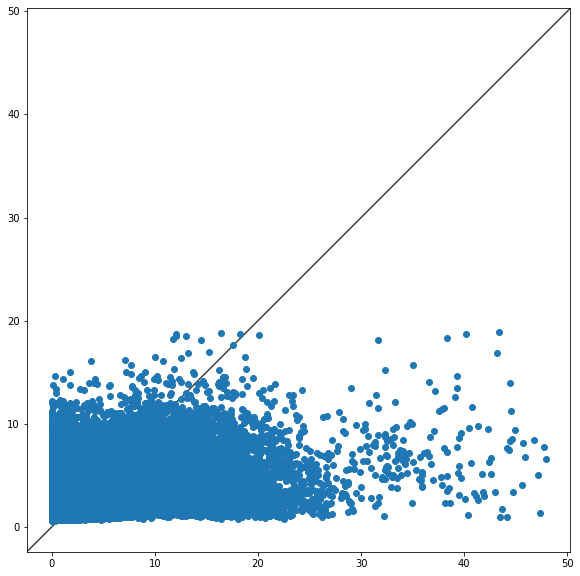

In [38]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With both

In [234]:
df = df_full.drop(columns=['index','hour_index']+weather_var, inplace = False)
df['leave_fuel'] = df['leave_fuel']/100
df['dist_to_station'] = df['dist_to_station']/5320
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203,dist_to_station
0,0.30,12.529378,0,1.000000,0.000364,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.072717
1,0.86,14.027280,0,0.999999,0.001018,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.206071
2,0.04,17.751882,0,0.999997,0.002327,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.152756
3,0.30,1.806991,0,0.999968,0.007999,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.168720
4,0.32,13.214864,0,0.999957,0.009236,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.112613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,0.94,20.556195,0,0.999934,-0.011490,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.051773
326588,0.59,14.221806,0,0.999970,-0.007708,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.102707
326589,0.48,16.451925,0,0.999980,-0.006327,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.115706
326590,0.23,15.140361,0,0.999990,-0.004363,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.093152


In [235]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2, random_state = 42)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data), random_state = 42)

train_data['degree'] = (train_data['degree']-1)/(train_data['degree'].max()-1)
val_data['degree'] = (val_data['degree']-1)/(val_data['degree'].max()-1)
test_data['degree'] = (test_data['degree']-1)/(test_data['degree'].max()-1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [236]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(271,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(128,32),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(32,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=271, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
) 38977


In [237]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 28.104820 , Valid Loss 21.533245 ,Train R2 -0.012381, Valid R2 -0.013140
Epoch 11: Train Loss 17.092209 , Valid Loss 16.699952 ,Train R2 0.217699, Valid R2 0.214267
Epoch 21: Train Loss 16.507936 , Valid Loss 16.268421 ,Train R2 0.244381, Valid R2 0.234570
Epoch 31: Train Loss 16.229932 , Valid Loss 16.171651 ,Train R2 0.258158, Valid R2 0.239123
Epoch 41: Train Loss 16.064729 , Valid Loss 16.124238 ,Train R2 0.267228, Valid R2 0.241354
Epoch 51: Train Loss 15.939118 , Valid Loss 16.098530 ,Train R2 0.273692, Valid R2 0.242563
Epoch 61: Train Loss 15.836293 , Valid Loss 16.073201 ,Train R2 0.279827, Valid R2 0.243755
Epoch 71: Train Loss 15.787565 , Valid Loss 16.035082 ,Train R2 0.285310, Valid R2 0.245549
Epoch 81: Train Loss 15.685865 , Valid Loss 16.006912 ,Train R2 0.289500, Valid R2 0.246874
Epoch 91: Train Loss 15.598703 , Valid Loss 15.993004 ,Train R2 0.293321, Valid R2 0.247529
EarlyStopping counter: 5 out of 10
Epoch 101: Train Loss 15.544441 , Valid Los

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

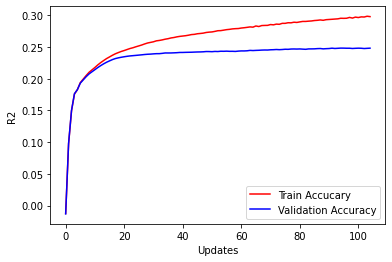

In [238]:
# setting hyperparameters and gettings epoch sizes
batch_size = 21772
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

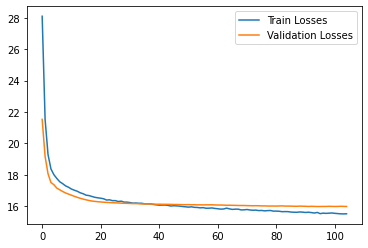

0.24818880344890693
0.25459415837432986


In [239]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(max(valid_r2))
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

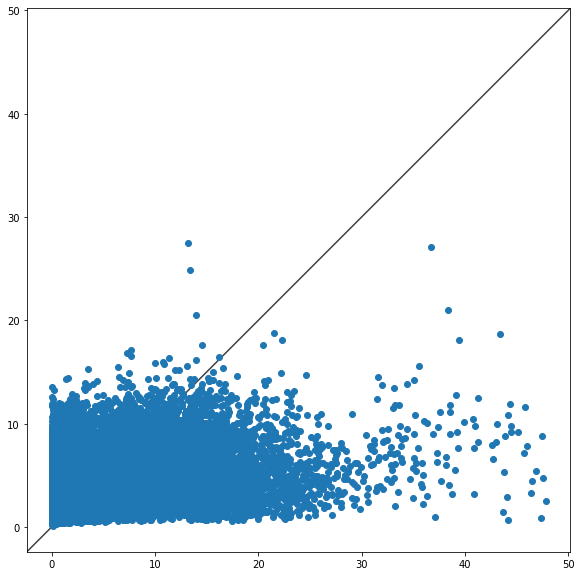

In [45]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With weather

In [240]:
df = df_full.drop(['index','hour_index']+list(df_full.filter(regex='Avg').columns),axis=1)
df['leave_fuel'] = df['leave_fuel']/100
df['dist_to_station'] = df['dist_to_station']/5320
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185154,lz_185203,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station
0,0.30,12.529378,0,1.000000,0.000364,0,0,1,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,0.072717
1,0.86,14.027280,0,0.999999,0.001018,0,0,1,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,0.206071
2,0.04,17.751882,0,0.999997,0.002327,1,0,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,0.152756
3,0.30,1.806991,0,0.999968,0.007999,0,0,1,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,0.168720
4,0.32,13.214864,0,0.999957,0.009236,0,1,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,0.112613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,0.94,20.556195,0,0.999934,-0.011490,0,0,1,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,0.051773
326588,0.59,14.221806,0,0.999970,-0.007708,1,0,0,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,0.102707
326589,0.48,16.451925,0,0.999980,-0.006327,1,0,0,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,0.115706
326590,0.23,15.140361,0,0.999990,-0.004363,0,0,1,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,0.093152


In [241]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2, random_state = 42)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data), random_state = 42)

train_data['degree'] = (train_data['degree']-1)/(train_data['degree'].max()-1)
val_data['degree'] = (val_data['degree']-1)/(val_data['degree'].max()-1)
test_data['degree'] = (test_data['degree']-1)/(test_data['degree'].max()-1)

minmax = True
if minmax:
    train_data = pd.concat([train_data.drop(columns = weather_var[:7]), (train_data[weather_var[:7]]-train_data[weather_var[:7]].min())/(train_data[weather_var[:7]].max()-train_data[weather_var[:7]].min())], axis = 1)
    val_data = pd.concat([val_data.drop(columns = weather_var[:7]), (val_data[weather_var[:7]]-val_data[weather_var[:7]].min())/(val_data[weather_var[:7]].max()-val_data[weather_var[:7]].min())], axis = 1)
    test_data = pd.concat([test_data.drop(columns = weather_var[:7]), (test_data[weather_var[:7]]-test_data[weather_var[:7]].min())/(test_data[weather_var[:7]].max()-test_data[weather_var[:7]].min())], axis = 1)
else:
    train_data = pd.concat([train_data.drop(columns = weather_var[:7]), (train_data[weather_var[:7]]-train_data[weather_var[:7]].mean())/(train_data[weather_var[:7]].std())], axis = 1)
    val_data = pd.concat([val_data.drop(columns = weather_var[:7]), (val_data[weather_var[:7]]-val_data[weather_var[:7]].mean())/(val_data[weather_var[:7]].std())], axis = 1)
    test_data = pd.concat([test_data.drop(columns = weather_var[:7]), (test_data[weather_var[:7]]-test_data[weather_var[:7]].mean())/(test_data[weather_var[:7]].std())], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [275]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(278,256),
            nn.ReLU(),#nn.BatchNorm1d(256)),
            nn.Dropout(0.15),
            nn.Linear(256,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.15),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.15),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=278, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.15, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.15, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 112641


In [276]:
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 24.087781 , Valid Loss 24.018164 ,Train R2 -0.127179, Valid R2 -0.130056
Epoch 11: Train Loss 16.928342 , Valid Loss 16.877630 ,Train R2 0.207845, Valid R2 0.205907
Epoch 21: Train Loss 16.034753 , Valid Loss 16.237299 ,Train R2 0.249660, Valid R2 0.236034
Epoch 31: Train Loss 15.528316 , Valid Loss 16.092554 ,Train R2 0.273358, Valid R2 0.242845
EarlyStopping counter: 5 out of 10
Epoch 41: Train Loss 15.111272 , Valid Loss 16.085643 ,Train R2 0.292874, Valid R2 0.243170
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 46: Train Loss 14.975465 , Valid Loss 16.123527 , Train R2 0.299229, Valid R2 0.241387


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

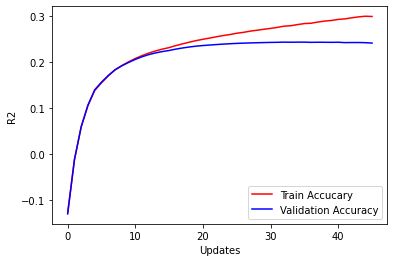

In [277]:
# setting hyperparameters and gettings epoch sizes
batch_size = 21772
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        #cur_loss_train.append(batch_loss.item())
    #train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

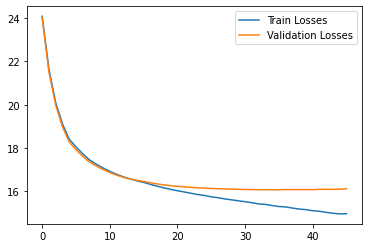

0.2434285280913454
0.24760182679944187


In [278]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(max(valid_r2))
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

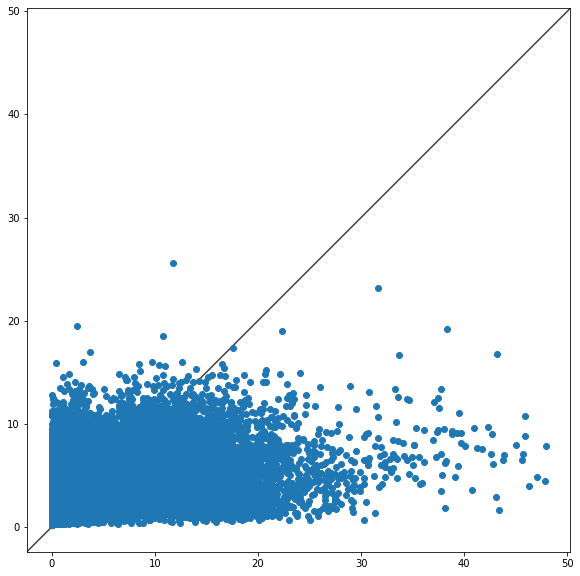

In [274]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## Average weather (cheat)

In [53]:
df = df_full.drop(['index','hour_index']+weather_var[:7]+weather_var[-7:],axis=1)
df['leave_fuel'] = df['leave_fuel']/100
df['dist_to_station'] = df['dist_to_station']/5320
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185154,lz_185203,Avg_mean_temp,Avg_mean_wind_speed,Avg_acc_precip,Avg_bright_sunshine,Avg_mean_pressure,Avg_mean_relative_hum,Avg_mean_cloud_cover,dist_to_station
0,0.30,12.529378,0,1.000000,0.000364,0,0,1,0,0,...,0,0,15.044444,1.688889,0.0,0.033333,1012.855556,73.877778,79.444444,0.072717
1,0.86,14.027280,0,0.999999,0.001018,0,0,1,0,0,...,0,0,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,0.206071
2,0.04,17.751882,0,0.999997,0.002327,1,0,0,0,0,...,0,0,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,0.152756
3,0.30,1.806991,0,0.999968,0.007999,0,0,1,0,0,...,0,0,14.433333,1.333333,0.0,0.000000,1013.450000,74.866667,81.166667,0.168720
4,0.32,13.214864,0,0.999957,0.009236,0,1,0,0,0,...,0,0,14.557143,1.357143,0.0,0.000000,1013.242857,75.128571,83.571429,0.112613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,0.94,20.556195,0,0.999934,-0.011490,0,0,1,0,0,...,0,0,4.214286,2.071429,0.0,0.000000,1019.414286,96.385714,41.857143,0.051773
326588,0.59,14.221806,0,0.999970,-0.007708,1,0,0,0,0,...,0,0,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,0.102707
326589,0.48,16.451925,0,0.999980,-0.006327,1,0,0,0,0,...,0,0,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,0.115706
326590,0.23,15.140361,0,0.999990,-0.004363,0,0,1,0,0,...,0,0,4.066667,1.916667,0.0,0.000000,1019.466667,96.183333,33.833333,0.093152


In [54]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data['degree'] = (train_data['degree']-1)/(train_data['degree'].max()-1)
val_data['degree'] = (val_data['degree']-1)/(val_data['degree'].max()-1)
test_data['degree'] = (test_data['degree']-1)/(test_data['degree'].max()-1)

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|weekend')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|weekend')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|weekend')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [55]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(278,256),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.33),
            nn.Linear(256,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.33),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.33),
            nn.Linear(64,1)
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=278, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.33, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.33, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.33, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 112641


In [56]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 15.614913 , Valid Loss 15.954166 ,Train R2 0.262116, Valid R2 0.255320
Epoch 11: Train Loss 8.821275 , Valid Loss 10.839779 ,Train R2 0.583150, Valid R2 0.494040
Epoch 21: Train Loss 7.253095 , Valid Loss 10.065184 ,Train R2 0.657254, Valid R2 0.530195
Epoch 31: Train Loss 6.162098 , Valid Loss 9.298912 ,Train R2 0.708809, Valid R2 0.565962
Epoch 41: Train Loss 5.411373 , Valid Loss 8.684885 ,Train R2 0.744285, Valid R2 0.594622
Epoch 51: Train Loss 4.727294 , Valid Loss 8.081785 ,Train R2 0.776611, Valid R2 0.622773
Epoch 61: Train Loss 4.490349 , Valid Loss 7.864883 ,Train R2 0.787808, Valid R2 0.632897
EarlyStopping counter: 5 out of 10
Epoch 71: Train Loss 4.150875 , Valid Loss 7.501080 ,Train R2 0.803850, Valid R2 0.649878
Epoch 81: Train Loss 3.998623 , Valid Loss 7.415589 ,Train R2 0.811045, Valid R2 0.653868
EarlyStopping counter: 5 out of 10
Epoch 91: Train Loss 3.951354 , Valid Loss 7.365294 ,Train R2 0.813278, Valid R2 0.656216
Epoch 101: Train Loss 3.68

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

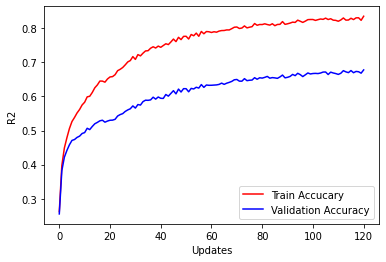

In [57]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        #cur_loss_train.append(batch_loss.item())
    #train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

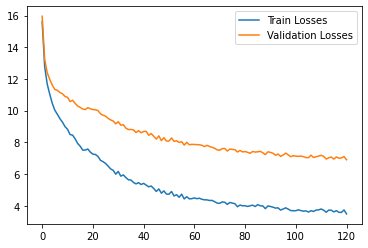

0.6842816730659451


In [58]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

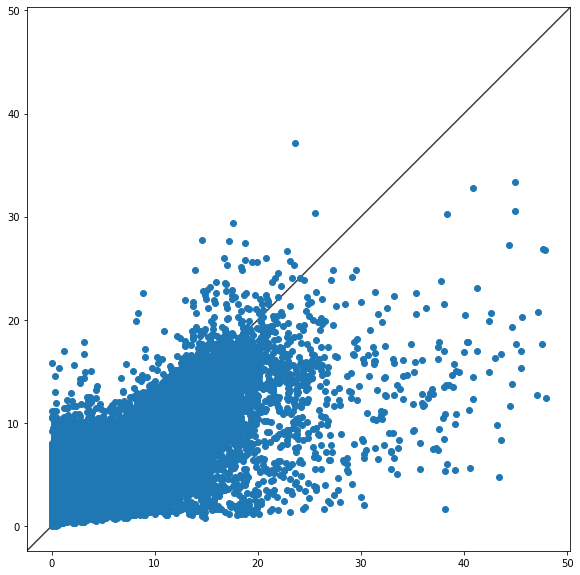

In [59]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## Only average weather

In [60]:
df_w = df_full[weather_var[7:14]+['dist_to_station']]
df_w

,Avg_mean_temp,Avg_mean_wind_speed,Avg_acc_precip,Avg_bright_sunshine,Avg_mean_pressure,Avg_mean_relative_hum,Avg_mean_cloud_cover,dist_to_station
0,15.044444,1.688889,0.0,0.033333,1012.855556,73.877778,79.444444,386.856080
1,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,1096.295483
2,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,812.660741
3,14.433333,1.333333,0.0,0.000000,1013.450000,74.866667,81.166667,897.592806
4,14.557143,1.357143,0.0,0.000000,1013.242857,75.128571,83.571429,599.103807
...,...,...,...,...,...,...,...,...
326587,4.214286,2.071429,0.0,0.000000,1019.414286,96.385714,41.857143,275.431500
326588,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,546.398658
326589,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,615.556913
326590,4.066667,1.916667,0.0,0.000000,1019.466667,96.183333,33.833333,495.570805


In [61]:
train_val, test_data, y_train_val, y_test = train_test_split(df_w, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|weekend')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|weekend')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|weekend')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [62]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(8,256),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.25),
            nn.Linear(256,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.25),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.25),
            nn.Linear(64,1)
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 43521


In [63]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 18.151287 , Valid Loss 17.540568 ,Train R2 0.152070, Valid R2 0.155379
Epoch 11: Train Loss 10.332846 , Valid Loss 9.990210 ,Train R2 0.517305, Valid R2 0.518947
Epoch 21: Train Loss 7.951806 , Valid Loss 7.802396 ,Train R2 0.628535, Valid R2 0.624295
Epoch 31: Train Loss 6.859329 , Valid Loss 6.800155 ,Train R2 0.679569, Valid R2 0.672556
Epoch 41: Train Loss 6.385899 , Valid Loss 6.376451 ,Train R2 0.701685, Valid R2 0.692958
Epoch 51: Train Loss 5.992083 , Valid Loss 6.071253 ,Train R2 0.720082, Valid R2 0.707654
Epoch 61: Train Loss 5.507341 , Valid Loss 5.648727 ,Train R2 0.742727, Valid R2 0.728000
EarlyStopping counter: 5 out of 10
Epoch 71: Train Loss 5.295500 , Valid Loss 5.424721 ,Train R2 0.752623, Valid R2 0.738786
Epoch 81: Train Loss 5.250022 , Valid Loss 5.375591 ,Train R2 0.754747, Valid R2 0.741152
EarlyStopping counter: 5 out of 10
Epoch 91: Train Loss 5.100984 , Valid Loss 5.285164 ,Train R2 0.761710, Valid R2 0.745506
EarlyStopping counter: 5 ou

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

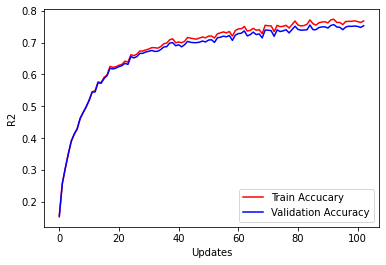

In [64]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

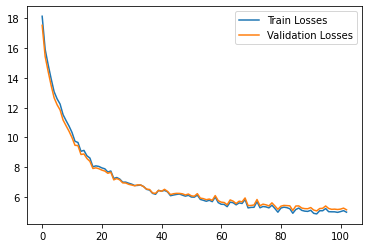

0.7495964635458567


In [65]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

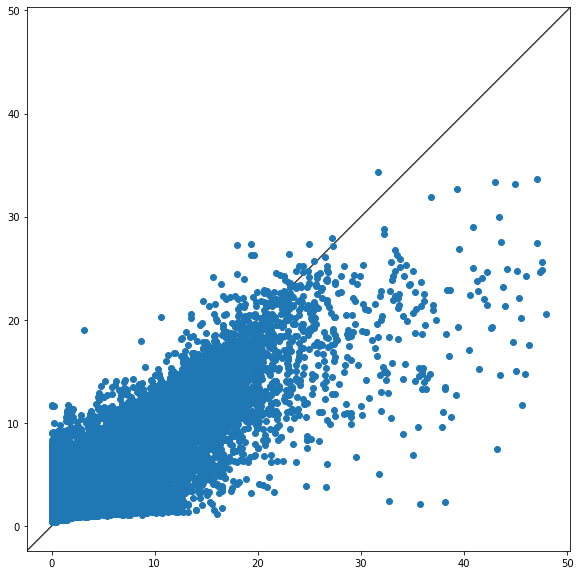

In [66]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With weather (index)

In [67]:
df = df_full.drop(['index','hour_index']+weather_var[:14],axis=1)
df['leave_fuel'] = df['leave_fuel']/100
df['dist_to_station'] = df['dist_to_station']/5320
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185154,lz_185203,Avg_Index_mean_temp,Avg_Index_mean_wind_speed,Avg_Index_acc_precip,Avg_Index_bright_sunshine,Avg_Index_mean_pressure,Avg_Index_mean_relative_hum,Avg_Index_mean_cloud_cover,dist_to_station
0,0.30,12.529378,0,1.000000,0.000364,0,0,1,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,0.072717
1,0.86,14.027280,0,0.999999,0.001018,0,0,1,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,0.206071
2,0.04,17.751882,0,0.999997,0.002327,1,0,0,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,0.152756
3,0.30,1.806991,0,0.999968,0.007999,0,0,1,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,0.168720
4,0.32,13.214864,0,0.999957,0.009236,0,1,0,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,0.112613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,0.94,20.556195,0,0.999934,-0.011490,0,0,1,0,0,...,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,0.051773
326588,0.59,14.221806,0,0.999970,-0.007708,1,0,0,0,0,...,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,0.102707
326589,0.48,16.451925,0,0.999980,-0.006327,1,0,0,0,0,...,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,0.115706
326590,0.23,15.140361,0,0.999990,-0.004363,0,0,1,0,0,...,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,0.093152


In [68]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data['degree'] = (train_data['degree']-1)/(train_data['degree'].max()-1)
val_data['degree'] = (val_data['degree']-1)/(val_data['degree'].max()-1)
test_data['degree'] = (test_data['degree']-1)/(test_data['degree'].max()-1)

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|weekend')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|weekend')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|weekend')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [69]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(278,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.4),
            nn.Linear(64,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.4),
            nn.Linear(64,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.4),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=278, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 26241


In [70]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.0004) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 17.979889 , Valid Loss 18.036362 ,Train R2 0.156946, Valid R2 0.153570
Epoch 11: Train Loss 15.716312 , Valid Loss 16.176173 ,Train R2 0.263082, Valid R2 0.240867
EarlyStopping counter: 5 out of 10
Epoch 21: Train Loss 15.589935 , Valid Loss 16.215390 ,Train R2 0.269008, Valid R2 0.239027
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 24: Train Loss 15.615418 , Valid Loss 16.277792 , Train R2 0.267813, Valid R2 0.236098


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

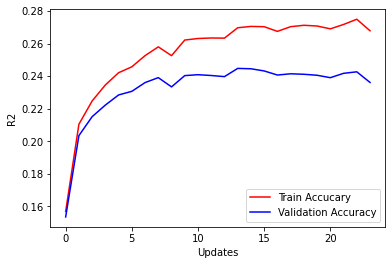

In [71]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

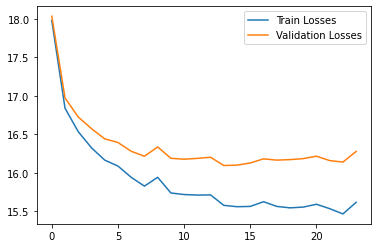

0.23689910026516614


In [72]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

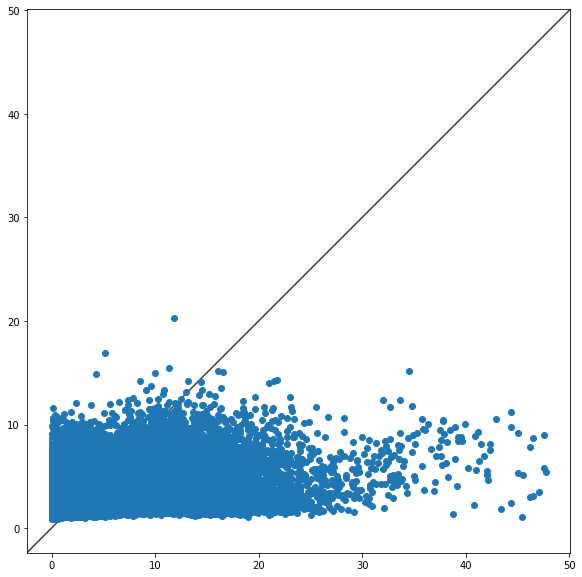

In [73]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With weather and embedding

In [312]:
df = df_full.drop(df_full.filter(regex='Avg').columns,axis=1)
df['Zone'] = df.filter(regex = 'lz').values.argmax(1)
df = df.drop(df.filter(regex='lz').columns,axis=1)
df = df.drop(columns = ['hour_index', 'index'])
df['leave_fuel'] = df['leave_fuel']/100
df['dist_to_station'] = df['dist_to_station']/5320
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station,Zone
0,0.30,12.529378,0,1.000000,0.000364,0,0,1,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,0.072717,209
1,0.86,14.027280,0,0.999999,0.001018,0,0,1,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,0.206071,138
2,0.04,17.751882,0,0.999997,0.002327,1,0,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,0.152756,56
3,0.30,1.806991,0,0.999968,0.007999,0,0,1,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,0.168720,235
4,0.32,13.214864,0,0.999957,0.009236,0,1,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,0.112613,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,0.94,20.556195,0,0.999934,-0.011490,0,0,1,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,0.051773,63
326588,0.59,14.221806,0,0.999970,-0.007708,1,0,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,0.102707,45
326589,0.48,16.451925,0,0.999980,-0.006327,1,0,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,0.115706,75
326590,0.23,15.140361,0,0.999990,-0.004363,0,0,1,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,0.093152,148


In [313]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data['degree'] = (train_data['degree']-1)/(train_data['degree'].max()-1)
val_data['degree'] = (val_data['degree']-1)/(val_data['degree'].max()-1)
test_data['degree'] = (test_data['degree']-1)/(test_data['degree'].max()-1)

minmax = False
if minmax:
    train_data = pd.concat([train_data.drop(columns = weather_var[:7]+['Zone']), (train_data[weather_var[:7]]-train_data[weather_var[:7]].min())/(train_data[weather_var[:7]].max()-train_data[weather_var[:7]].min()),train_data.Zone], axis = 1)
    val_data = pd.concat([val_data.drop(columns = weather_var[:7]+['Zone']), (val_data[weather_var[:7]]-val_data[weather_var[:7]].min())/(val_data[weather_var[:7]].max()-val_data[weather_var[:7]].min()),val_data.Zone], axis = 1)
    test_data = pd.concat([test_data.drop(columns = weather_var[:7]+['Zone']), (test_data[weather_var[:7]]-test_data[weather_var[:7]].min())/(test_data[weather_var[:7]].max()-test_data[weather_var[:7]].min()),test_data.Zone], axis = 1)
else:
    train_data = pd.concat([train_data.drop(columns = weather_var[:7]+['Zone']), (train_data[weather_var[:7]]-train_data[weather_var[:7]].mean())/(train_data[weather_var[:7]].std()),train_data.Zone], axis = 1)
    val_data = pd.concat([val_data.drop(columns = weather_var[:7]+['Zone']), (val_data[weather_var[:7]]-val_data[weather_var[:7]].mean())/(val_data[weather_var[:7]].std()),val_data.Zone], axis = 1)
    test_data = pd.concat([test_data.drop(columns = weather_var[:7]+['Zone']), (test_data[weather_var[:7]]-test_data[weather_var[:7]].mean())/(test_data[weather_var[:7]].std()),test_data.Zone], axis = 1)
    
X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [314]:
train_data

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,dist_to_station,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,Zone
26044,0.42,0.150100,1,-0.772734,0.634731,0,0,1,0,0.044885,1.194275,-0.879685,-0.257288,2.603677,1.419074,0.734850,-1.683542,5
115502,0.61,0.150784,1,0.002109,-0.999998,0,0,1,0,0.160416,0.689213,-0.775540,0.127880,1.701833,-0.488647,-0.081267,-1.059246,171
129165,0.66,0.154734,0,0.967636,-0.252351,0,0,1,0,0.092780,-0.591480,-1.504557,-0.257288,-0.537048,0.460372,-0.818149,0.865668,124
7812,0.81,0.137966,1,0.096208,-0.995361,0,0,1,0,0.130456,1.392692,0.005551,-0.064704,-0.537048,-0.362757,-0.025802,0.865668,18
43800,0.65,0.064945,1,-0.990619,0.136652,0,0,1,0,0.092840,1.951868,0.213841,-0.257288,-0.447912,-0.236867,-0.445746,-0.278875,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210197,0.94,0.138161,0,0.999268,-0.038242,1,0,0,0,0.062166,-0.753821,0.161769,0.127880,-0.537048,-1.544188,0.711080,0.917693,185
39331,0.26,0.385933,0,0.303063,-0.952971,0,0,1,0,0.079518,1.825603,-0.983830,-0.257288,1.701833,1.099507,-0.976618,-1.553480,14
275860,0.41,0.147069,1,-0.802774,-0.596283,0,1,0,0,0.125829,-1.186731,-0.358958,-0.257288,1.062153,0.731520,-0.754761,-1.657530,10
150905,0.25,0.296002,1,-0.896358,0.443332,1,0,0,0,0.221976,0.202189,0.682495,-0.257288,-0.421696,-0.769479,0.394141,-1.137283,134


In [356]:
# define network
class Net(nn.Module):

    def __init__(self, emb_dim):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding(261,emb_dim)

        self.seq = nn.Sequential(
            nn.Linear(17+emb_dim,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.1),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.1),
            #nn.Linear(128,64),
            #nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.15),
            nn.Linear(64,1)
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x_emb_in = x[:,-1].long()
        x_emb_out = self.embedding(x_emb_in)
        x = torch.cat([x[:,:-1],x_emb_out], axis = 1)
        x = self.seq(x)
        return x


net = Net(emb_dim = 8)
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (embedding): Embedding(261, 8)
  (seq): Sequential(
    (0): Linear(in_features=25, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Dropout(p=0.15, inplace=False)
    (7): Linear(in_features=64, out_features=1, bias=True)
  )
) 13737


In [358]:
optimizer = optim.Adam(net.parameters(), lr=0.002, weight_decay = 0.00005) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 22.469624 , Valid Loss 22.800234 ,Train R2 -0.056445, Valid R2 -0.056721
Epoch 11: Train Loss 18.521150 , Valid Loss 18.738047 ,Train R2 0.129199, Valid R2 0.131549
Epoch 21: Train Loss 17.254261 , Valid Loss 17.546063 ,Train R2 0.188763, Valid R2 0.186794
Epoch 31: Train Loss 16.651341 , Valid Loss 17.027236 ,Train R2 0.217111, Valid R2 0.210840
Epoch 41: Train Loss 16.417455 , Valid Loss 16.833361 ,Train R2 0.228107, Valid R2 0.219825
Epoch 51: Train Loss 16.253935 , Valid Loss 16.699435 ,Train R2 0.235795, Valid R2 0.226032
Epoch 61: Train Loss 16.127784 , Valid Loss 16.609397 ,Train R2 0.241727, Valid R2 0.230205
Epoch 71: Train Loss 16.029557 , Valid Loss 16.538191 ,Train R2 0.246345, Valid R2 0.233505
Epoch 81: Train Loss 15.943577 , Valid Loss 16.478352 ,Train R2 0.250387, Valid R2 0.236279
Epoch 91: Train Loss 15.874835 , Valid Loss 16.444038 ,Train R2 0.253619, Valid R2 0.237869
Epoch 101: Train Loss 15.811691 , Valid Loss 16.412547 ,Train R2 0.256588, Val

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

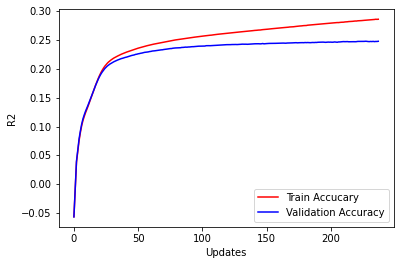

In [359]:
# setting hyperparameters and gettings epoch sizes
batch_size = 21772
num_epochs = 301
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

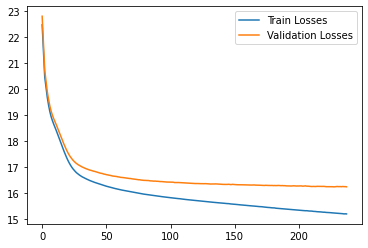

0.24778324451153977
0.25211561146497474


In [360]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(max(valid_r2))
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

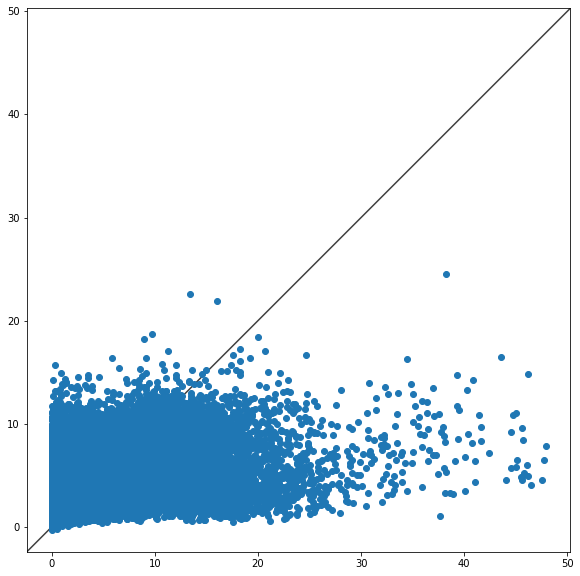

In [361]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

In [81]:
net.forward(X_test).detach().numpy()[:,0].argsort()[::-1]

array([38581, 64891, 64305, ..., 38572, 38638, 37690])

In [82]:
net.forward(X_test).detach().numpy()[:,0][9057]

5.5488987

In [83]:
test_data.iloc[9057]

leave_fuel            0.630000
degree                0.168129
weekend               1.000000
Time_Cos              0.922370
Time_Sin             -0.386309
eng_118I              0.000000
eng_COOPER            0.000000
eng_I3                1.000000
eng_X1                0.000000
dist_to_station       0.054574
Zone                 29.000000
mean_temp             0.421222
mean_wind_speed       0.008772
acc_precip            0.000000
bright_sunshine       0.000000
mean_pressure         0.756917
mean_relative_hum     0.945736
mean_cloud_cover      0.160000
Name: 98341, dtype: float64

In [84]:
X_test

tensor([[0.3800, 0.1655, 0.0000,  ..., 0.8656, 0.9085, 0.9800],
        [0.2600, 0.1365, 0.0000,  ..., 0.6225, 0.3845, 0.6300],
        [0.4400, 0.0477, 0.0000,  ..., 0.4012, 0.8961, 0.5500],
        ...,
        [0.8200, 0.2541, 1.0000,  ..., 0.5099, 0.9364, 0.7000],
        [0.5200, 0.1034, 1.0000,  ..., 0.4881, 0.9116, 0.9900],
        [0.4500, 0.2106, 0.0000,  ..., 0.4012, 0.5798, 0.0700]])

## With average weather and embedding

In [85]:
df = df_full.drop(['index','hour_index']+weather_var[:14],axis=1)
df['Zone'] = df.filter(regex = 'lz').values.argmax(1)
df = df.drop(df.filter(regex='lz').columns,axis=1)
df['leave_fuel'] = df['leave_fuel']/100
df['dist_to_station'] = df['dist_to_station']/5320
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,Avg_Index_mean_temp,Avg_Index_mean_wind_speed,Avg_Index_acc_precip,Avg_Index_bright_sunshine,Avg_Index_mean_pressure,Avg_Index_mean_relative_hum,Avg_Index_mean_cloud_cover,dist_to_station,Zone
0,0.30,12.529378,0,1.000000,0.000364,0,0,1,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,0.072717,209
1,0.86,14.027280,0,0.999999,0.001018,0,0,1,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,0.206071,138
2,0.04,17.751882,0,0.999997,0.002327,1,0,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,0.152756,56
3,0.30,1.806991,0,0.999968,0.007999,0,0,1,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,0.168720,235
4,0.32,13.214864,0,0.999957,0.009236,0,1,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,0.112613,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,0.94,20.556195,0,0.999934,-0.011490,0,0,1,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,0.051773,63
326588,0.59,14.221806,0,0.999970,-0.007708,1,0,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,0.102707,45
326589,0.48,16.451925,0,0.999980,-0.006327,1,0,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,0.115706,75
326590,0.23,15.140361,0,0.999990,-0.004363,0,0,1,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,0.093152,148


In [86]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data['degree'] = (train_data['degree']-1)/(train_data['degree'].max()-1)
val_data['degree'] = (val_data['degree']-1)/(val_data['degree'].max()-1)
test_data['degree'] = (test_data['degree']-1)/(test_data['degree'].max()-1)

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|Zone|weekend')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|Zone|weekend')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|Zone|weekend')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [87]:
# define network
class Net(nn.Module):

    def __init__(self, emb_dim):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding(261,emb_dim)

        self.seq = nn.Sequential(
            nn.Linear(17+emb_dim,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(128,128),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x_emb_in = x[:,-1].long()
        x_emb_out = self.embedding(x_emb_in)
        x = torch.cat([x[:,:-1],x_emb_out], axis = 1)
        x = self.seq(x)
        return x


net = Net(emb_dim = 8)
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (embedding): Embedding(261, 8)
  (seq): Sequential(
    (0): Linear(in_features=25, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 30249


In [88]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 18.072934 , Valid Loss 18.054867 ,Train R2 0.147972, Valid R2 0.142211
Epoch 11: Train Loss 15.807742 , Valid Loss 16.035598 ,Train R2 0.254762, Valid R2 0.238146
Epoch 21: Train Loss 15.356329 , Valid Loss 15.779338 ,Train R2 0.276044, Valid R2 0.250321
Epoch 31: Train Loss 15.031533 , Valid Loss 15.734768 ,Train R2 0.291356, Valid R2 0.252439
EarlyStopping counter: 5 out of 10
Epoch 41: Train Loss 14.903791 , Valid Loss 15.757378 ,Train R2 0.297378, Valid R2 0.251365
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 49: Train Loss 14.719522 , Valid Loss 15.765486 , Train R2 0.306065, Valid R2 0.250979


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

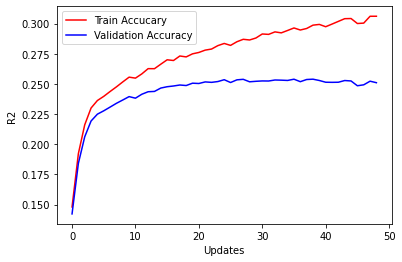

In [89]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

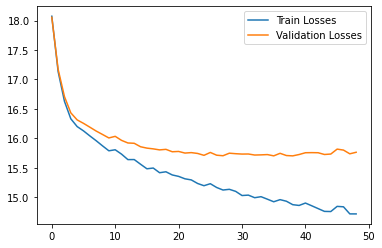

0.25442484969071244


In [90]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

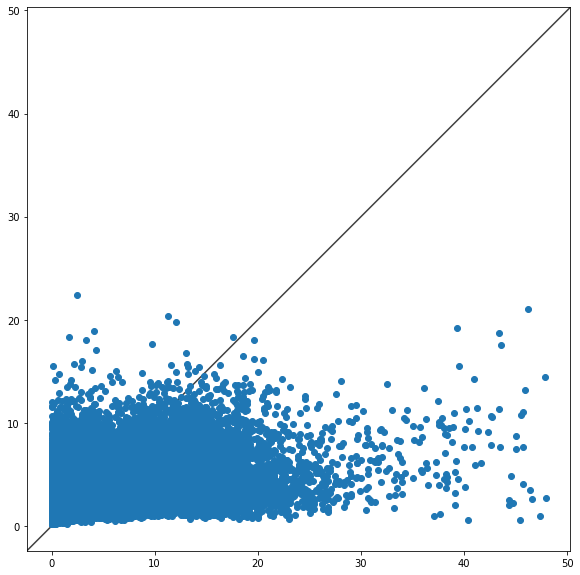

In [91]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

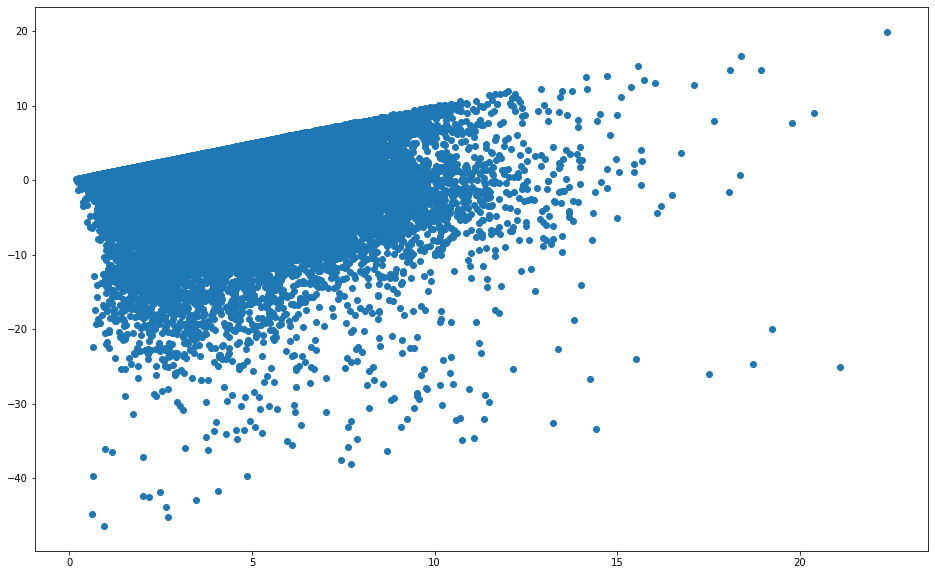

In [92]:
fig, ax = plt.subplots(figsize = (16,10))
ax.scatter(net.forward(X_test).detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]-y_test.detach().numpy()[:,0])
plt.show()

In [93]:
np.corrcoef(net.forward(X_test).detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]-y_test.detach().numpy()[:,0])

array([[ 1.        , -0.04294119],
       [-0.04294119,  1.        ]])

In [94]:
np.mean(net.forward(X_test).detach().numpy()[:,0]-y_test.detach().numpy()[:,0])

-0.19191168

## Embedding and cheating with weather

In [95]:
df = df_full.drop(['index','hour_index']+weather_var[:7]+weather_var[-7:],axis=1)
df['Zone'] = df.filter(regex = 'lz').values.argmax(1)
df = df.drop(df.filter(regex='lz').columns,axis=1)
df['leave_fuel'] = df['leave_fuel']/100
df['dist_to_station'] = df['dist_to_station']/5320
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,Avg_mean_temp,Avg_mean_wind_speed,Avg_acc_precip,Avg_bright_sunshine,Avg_mean_pressure,Avg_mean_relative_hum,Avg_mean_cloud_cover,dist_to_station,Zone
0,0.30,12.529378,0,1.000000,0.000364,0,0,1,0,15.044444,1.688889,0.0,0.033333,1012.855556,73.877778,79.444444,0.072717,209
1,0.86,14.027280,0,0.999999,0.001018,0,0,1,0,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,0.206071,138
2,0.04,17.751882,0,0.999997,0.002327,1,0,0,0,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,0.152756,56
3,0.30,1.806991,0,0.999968,0.007999,0,0,1,0,14.433333,1.333333,0.0,0.000000,1013.450000,74.866667,81.166667,0.168720,235
4,0.32,13.214864,0,0.999957,0.009236,0,1,0,0,14.557143,1.357143,0.0,0.000000,1013.242857,75.128571,83.571429,0.112613,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,0.94,20.556195,0,0.999934,-0.011490,0,0,1,0,4.214286,2.071429,0.0,0.000000,1019.414286,96.385714,41.857143,0.051773,63
326588,0.59,14.221806,0,0.999970,-0.007708,1,0,0,0,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,0.102707,45
326589,0.48,16.451925,0,0.999980,-0.006327,1,0,0,0,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,0.115706,75
326590,0.23,15.140361,0,0.999990,-0.004363,0,0,1,0,4.066667,1.916667,0.0,0.000000,1019.466667,96.183333,33.833333,0.093152,148


In [96]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data['degree'] = (train_data['degree']-1)/(train_data['degree'].max()-1)
val_data['degree'] = (val_data['degree']-1)/(val_data['degree'].max()-1)
test_data['degree'] = (test_data['degree']-1)/(test_data['degree'].max()-1)

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|Zone|weekend')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|Zone|weekend')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|Zone|weekend')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [97]:
# define network
class Net(nn.Module):

    def __init__(self, emb_dim):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding(261,emb_dim)

        self.seq = nn.Sequential(
            nn.Linear(17+emb_dim,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(128,128),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x_emb_in = x[:,-1].long()
        x_emb_out = self.embedding(x_emb_in)
        x = torch.cat([x[:,:-1],x_emb_out], axis = 1)
        x = self.seq(x)
        return x


net = Net(emb_dim = 8)
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (embedding): Embedding(261, 8)
  (seq): Sequential(
    (0): Linear(in_features=25, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 30249


In [98]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 17.219260 , Valid Loss 17.895021 ,Train R2 0.187314, Valid R2 0.180876
Epoch 11: Train Loss 9.183982 , Valid Loss 10.130349 ,Train R2 0.566550, Valid R2 0.536295
Epoch 21: Train Loss 7.212748 , Valid Loss 8.257404 ,Train R2 0.659585, Valid R2 0.622027
Epoch 31: Train Loss 5.935505 , Valid Loss 7.061909 ,Train R2 0.719866, Valid R2 0.676749
Epoch 41: Train Loss 5.223679 , Valid Loss 6.415268 ,Train R2 0.753462, Valid R2 0.706349
EarlyStopping counter: 5 out of 10
Epoch 51: Train Loss 4.859365 , Valid Loss 6.143552 ,Train R2 0.770656, Valid R2 0.718786
EarlyStopping counter: 5 out of 10
Epoch 61: Train Loss 4.633217 , Valid Loss 5.964923 ,Train R2 0.781329, Valid R2 0.726963
Epoch 71: Train Loss 4.219131 , Valid Loss 5.550050 ,Train R2 0.800873, Valid R2 0.745953
Epoch 81: Train Loss 4.258588 , Valid Loss 5.627787 ,Train R2 0.799010, Valid R2 0.742395
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 87: Train Loss 4.335378 ,

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

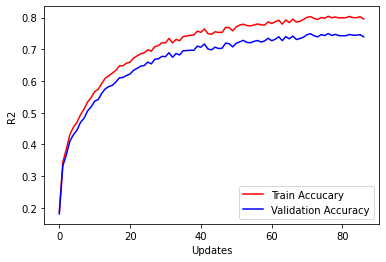

In [99]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

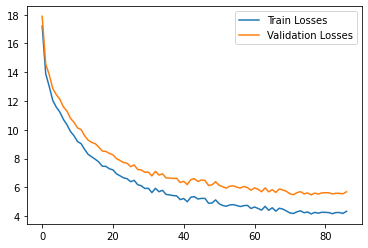

0.7363919319007817


In [100]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

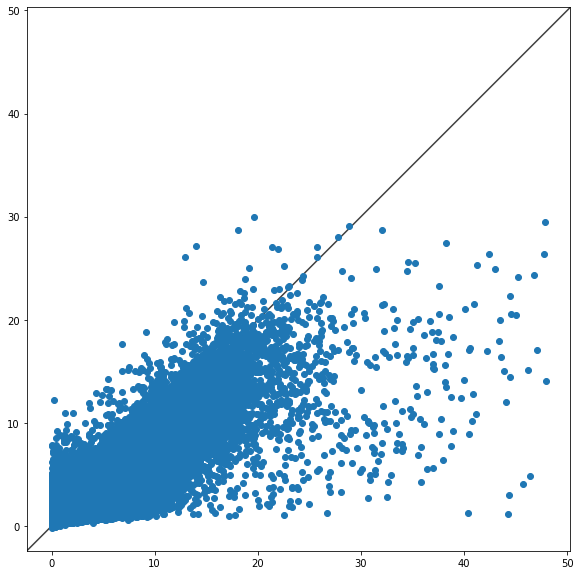

In [101]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()